#### *Clustering Project based on online retail dataset*

Objectives:                                                                                                                                                 
   - Do customer segmentation/clustering
   - Describe each groups behaviours

In [1]:
#import all the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from scipy.stats import skew, norm, probplot, boxcox
import datetime
import math
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from joblib import dump, load

In [2]:
df = pd.read_excel('D:/Assignments/Clustering_project/data/Online Retail.xlsx') # Reading excel file
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data cleaning and visualization

In [3]:
# cheching if there is any missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

###### As we can see Description and CustomerID have missing values so we need to handle these missing values first

In [4]:
df1 = df.copy()

In [5]:
df1.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


###### The describe() function computes a summary of statistical data.

###### From the above output we can see that the Quantity and the UnitPrice are having negative values, which may mean that we may have some return transactions in our data.Also, as our goal is customer segmentation or clustering, it is important that these records are removed, but first we will take a look at whether there are records where both are negative or if one of them is negative and the other is zero.

In [6]:
print('Check if we had negative quantity and prices at the same register:')
if df1[(df1.Quantity<0) & (df1.UnitPrice<0)].shape[0] == 0:
    print("No")
else:
    print("Yes")

Check if we had negative quantity and prices at the same register:
No


In [7]:
print(f"Check how many register we have where quantity is negative and prices is 0 or vice-versa: {df1[(df1.Quantity<=0) & (df1.UnitPrice<=0)].shape[0]}")

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336


In [8]:
print(f"What is the customer ID of the registers above: {df1.loc[(df1.Quantity<=0) & (df1.UnitPrice<=0), ['CustomerID']].CustomerID.unique()}")

What is the customer ID of the registers above: [nan]


In [9]:
print('Negative Quantity: {:3.2%}'.format(df1[(df1.Quantity<0)].shape[0]/df1.shape[0]))

Negative Quantity: 1.96%


In [10]:
print(f"All register with negative quantity has Invoice start with: {df1.loc[(df1.Quantity<0) & ~(df1.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique()}")

All register with negative quantity has Invoice start with: ['C']


In [11]:
print(F"Sales records with Customer ID and zero in Unit Price: {df1[(df1.UnitPrice==0)  & ~(df1.CustomerID.isnull())].shape[0]}")
df1[(df1.UnitPrice==0)  & ~(df1.CustomerID.isnull())]

Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,2010-12-05 14:02:00,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,2010-12-16 14:36:00,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,2010-12-21 13:45:00,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,2011-01-06 16:41:00,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,2011-01-13 15:10:00,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2011-02-10 13:08:00,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,2011-03-23 10:25:00,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,2011-03-30 12:45:00,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,2011-04-04 14:42:00,0.0,14410.0,United Kingdom


###### From the above inspection we can see, there are no records where quantity and price are negative, but there are 1336 records where one of them is negative and the other is 0. However, for all these records we do not have the customer ID. So we can erase all records in that quantity or the price and negative.

In [12]:
# Remove register without CustomerID
df1 = df1[~(df1.CustomerID.isnull())]

# Remove negative or return transactions
df1 = df1[~(df1.Quantity<0)]
df1 = df1[df1.UnitPrice>0]

In [13]:
# cheching now if there are any missing values
df1.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

###### No missing values detected

<AxesSubplot:>

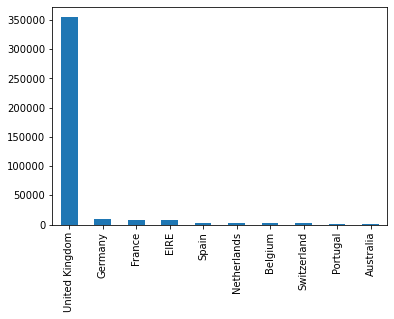

In [14]:
#Top 10 Most common countries
df1.Country.value_counts()[:10].plot(kind='bar')

<AxesSubplot:xlabel='Country'>

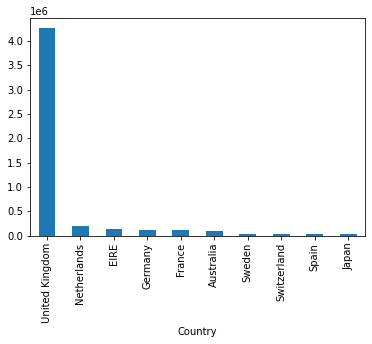

In [15]:
# Top 10 countries by Total quantity
df1.groupby('Country')['Quantity'].sum().sort_values(ascending=False)[:10].plot(kind='bar')

<AxesSubplot:xlabel='Country'>

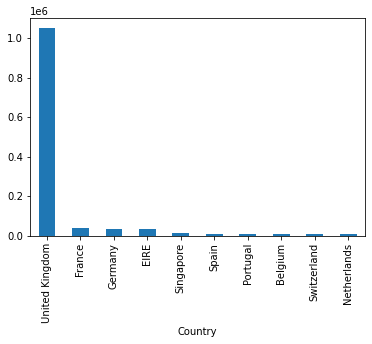

In [16]:
# Top 10 countries by Total unitprice
df1.groupby('Country')['UnitPrice'].sum().sort_values(ascending=False)[:10].plot(kind='bar')

<AxesSubplot:xlabel='InvoiceNo'>

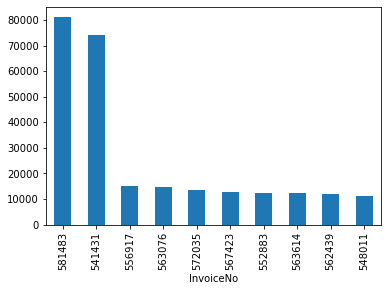

In [17]:
#Total quantity sold by invoiceno [Top 10]
df1.groupby('InvoiceNo')['Quantity'].sum().sort_values(ascending=False)[:10].plot(kind='bar')

In [18]:
df2 = df1.copy()

In [19]:
df2.InvoiceDate = pd.to_datetime(df2.InvoiceDate)

In [20]:
# Create a new Features 'year' from 'invoicedate'
df2['year'] = df2['InvoiceDate'].dt.year
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010


<AxesSubplot:xlabel='year'>

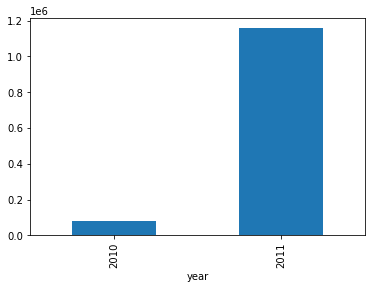

In [21]:
# Total unitprice sold by year
df2.groupby('year')['UnitPrice'].sum().plot(kind='bar')

<AxesSubplot:xlabel='year'>

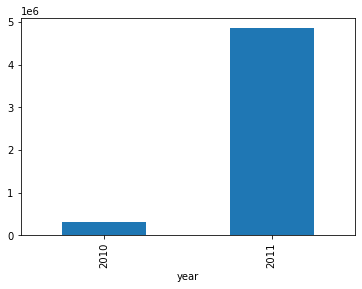

In [22]:
# Total quantity sold by year
df2.groupby('year')['Quantity'].sum().plot(kind='bar')

###### Now for customer segmentation we are going to use k-means clustering.

###### RFM Model for Customer Value:
As we have limited data we will use a RFM (Recency, Frequency and Monetary Value) based model of customer value.This RFM model will take the transactions of a customer and calculate three important informational attributes about each customer for segmenting customers:

Recency: The value of how recently a customer purchased at the establishment
Frequency: How frequent the customer’s transactions are at the establishment
Monetary value: The currency value of all the transactions that the customer made at the establishment

###### Recency
To create the recency feature variable, we need to decide the reference date. We will make use of the last transaction date plus one day. That will be our reference date

In [23]:
df1.InvoiceDate = pd.to_datetime(df1.InvoiceDate)

In [24]:
refrence_date = df1.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)

Reference Date: 2011-12-10 12:50:00


Now, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase and then describe the data.

In [25]:
df1['days_since_last_purchase'] = (refrence_date - df1.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  df1[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0


###### Now we calculate frequency 

In [26]:
customer_freq = (df1[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)

In [27]:
customer_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.0,13813.25,15299.5,16778.75,18287.0
recency,4338.0,92.536422,100.014169,1.0,18.00,51.0,142.00,374.0
frequency,4338.0,4.272015,7.697998,1.0,1.00,2.0,5.00,209.0


###### We can get the total amount from quantity and unitprice and this will be considered as the Monetary value

In [28]:
df1["amount"] = df1.Quantity * df1.UnitPrice

In [29]:
customer_monetary_val = df1[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)

In [30]:
customer_history_df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4338.0,15300.408022,1721.808492,12346.00,13813.250,15299.500,16778.75,18287.00
recency,4338.0,92.536422,100.014169,1.00,18.000,51.000,142.00,374.00
frequency,4338.0,4.272015,7.697998,1.00,1.000,2.000,5.00,209.00
amount,4338.0,2054.266460,8989.230441,3.75,307.415,674.485,1661.74,280206.02


###### Now we plot the distrubution of recency, frequency and monetary value

Text(0, 0.5, 'Frequency')

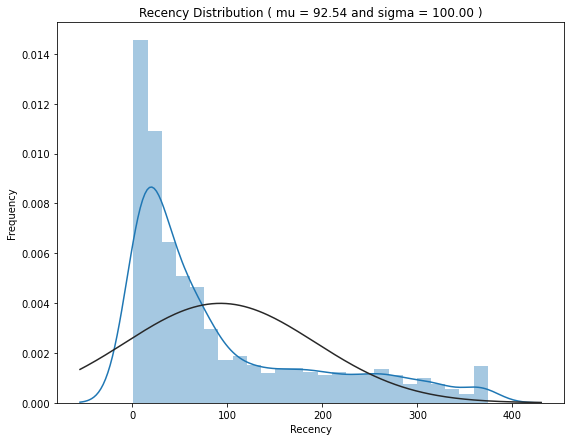

In [31]:
fig = plt.figure(figsize=(20,7))

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(customer_history_df.recency)

#Kernel Density plot
fig1 = fig.add_subplot(121)
sns.distplot(customer_history_df.recency, fit=norm)
fig1.set_title('Recency' + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
fig1.set_xlabel('Recency')
fig1.set_ylabel('Frequency')

###### The above graph shows that sales recency distribution is right skewed. It deviates from normal distribution and is positively biased.

Text(0, 0.5, 'Frequency')

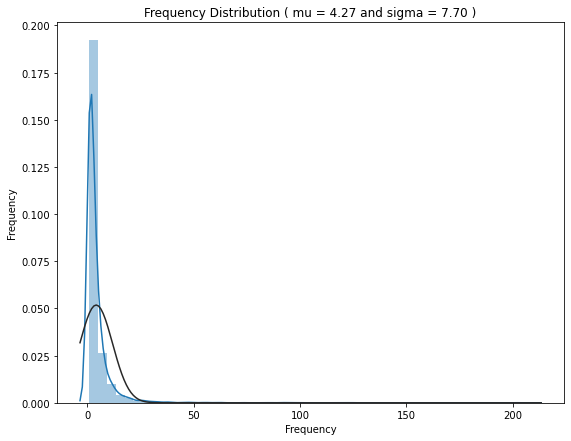

In [32]:
fig = plt.figure(figsize=(20,7))

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(customer_history_df.frequency)

#Kernel Density plot
fig1 = fig.add_subplot(121)
sns.distplot(customer_history_df.frequency, fit=norm)
fig1.set_title('Frequency' + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
fig1.set_xlabel('Frequency')
fig1.set_ylabel('Frequency')

###### The above graph shows that sales frequency distribution is right skewed. It deviates from normal distribution and is positively biased.

Text(0, 0.5, 'Frequency')

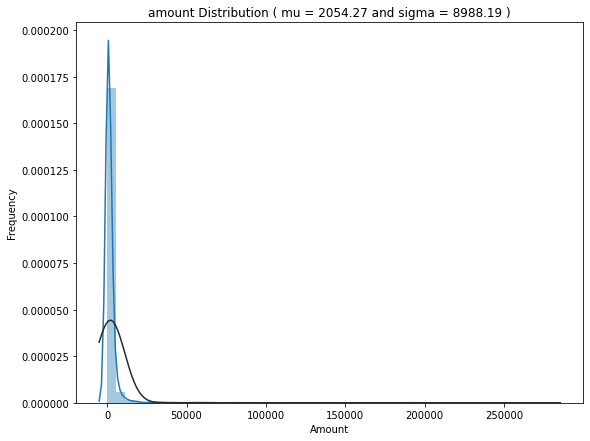

In [33]:
fig = plt.figure(figsize=(20,7))

#Get the fitted parameters used by the function
(mu, sigma) = norm.fit(customer_history_df.amount)

#Kernel Density plot
fig1 = fig.add_subplot(121)
sns.distplot(customer_history_df.amount, fit=norm)
fig1.set_title('amount' + ' Distribution ( mu = {:.2f} and sigma = {:.2f} )'.format(mu, sigma), loc='center')
fig1.set_xlabel('Amount')
fig1.set_ylabel('Frequency')

###### The above graph shows that sales monetary value distribution is right skewed. It deviates from normal distribution and is positively biased.

### Data preprocessing and customer segmentation 

For our clustering, we will be using the K-means clustering algorithm.For proper functioning of the algorithm is the mean centering of the variable values. Mean centering of a variable value means that we will replace the actual value of the variable with a standardized value, so that the variable has a mean of 0 and variance of 1. This ensures that all the variables are in the same range and the difference in ranges of values doesn't cause the algorithm to not perform well. This is akin to feature scaling.

We will also transform all the variables on the log scale in order to investigate the huge range of values each variable can take. This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and transformed values.

In [34]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

,count,mean,std,min,25%,50%,75%,max
amount_log,4338.0,-8.022628e-16,1.000115,-4.179280,-0.684183,-0.060942,0.654244,4.721395
recency_log,4338.0,-1.027980e-16,1.000115,-2.630445,-0.612424,0.114707,0.829652,1.505796
frequency_log,4338.0,-2.355833e-16,1.000115,-1.048610,-1.048610,-0.279044,0.738267,4.882714


<AxesSubplot:xlabel='frequency_log', ylabel='amount_log'>

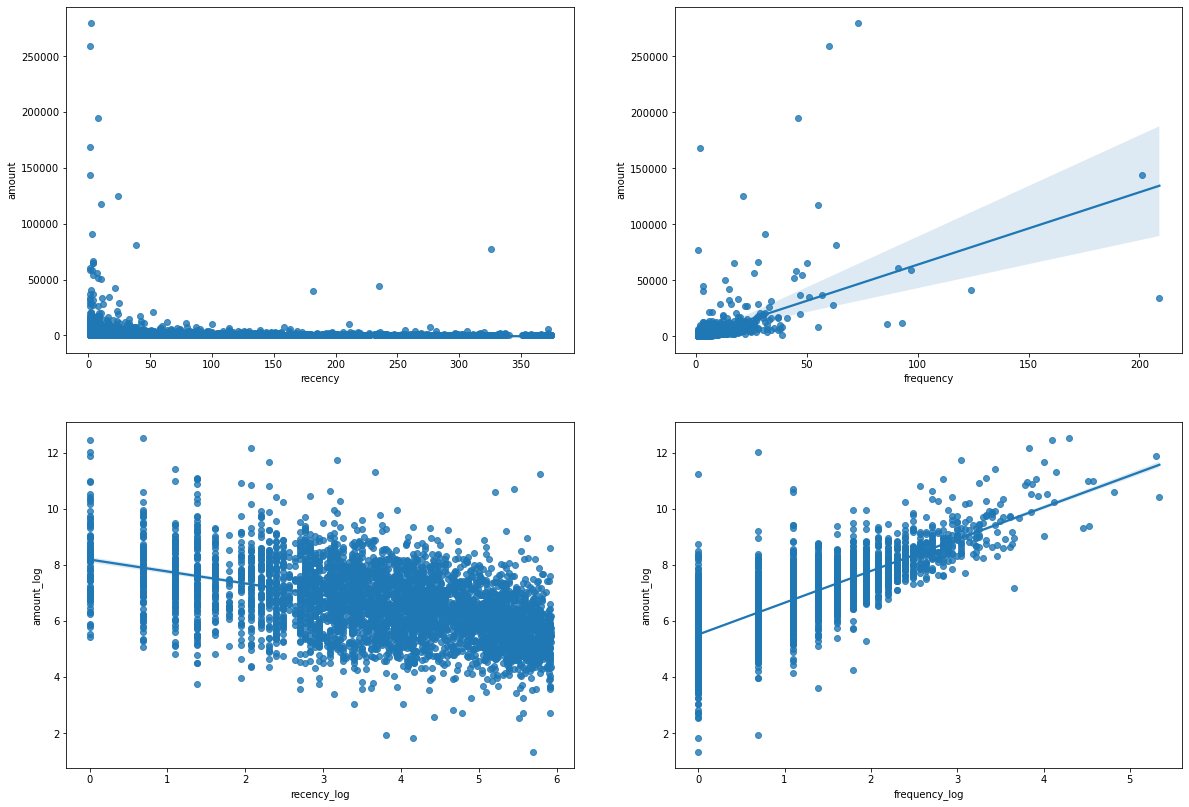

In [35]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

From the above plots we can see that the customers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively.

###### Elbow method to get the optimal number of clusters

Text(0, 0.5, 'Inertia Score')

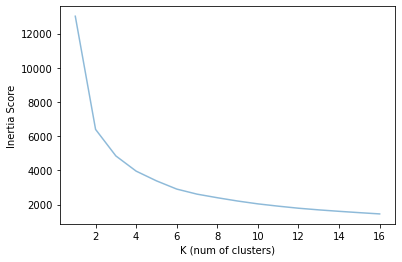

In [36]:
wcss = []
max_range = 17

for k in range(1, max_range): 
    kmeans = KMeans( n_clusters=k, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=101)
    kmeans.fit(X_scaled)
    labels = kmeans.labels_
    interia = kmeans.inertia_
    wcss.append(interia)

#plt.plot(np.arange(1 , max_range) , wcss , 'o')
plt.plot(np.arange(1 , max_range) , wcss , '-' , alpha = 0.5)

plt.xlabel("K (num of clusters)")
plt.ylabel("Inertia Score")


###### From the above graph it can be said the optimal number clusters can be in between 2 to 7. We can validate this by performing the silhouette_score

In [37]:
dump(kmeans, 'D:/Assignments/Clustering_project/models/kmeans_model.joblib')

['D:/Assignments/Clustering_project/models/kmeans_model.joblib']

In [38]:
load_model = load('D:/Assignments/Clustering_project/models/kmeans_model.joblib')
load_model.predict(X_scaled)

array([11,  7,  6, ..., 15,  5,  6])

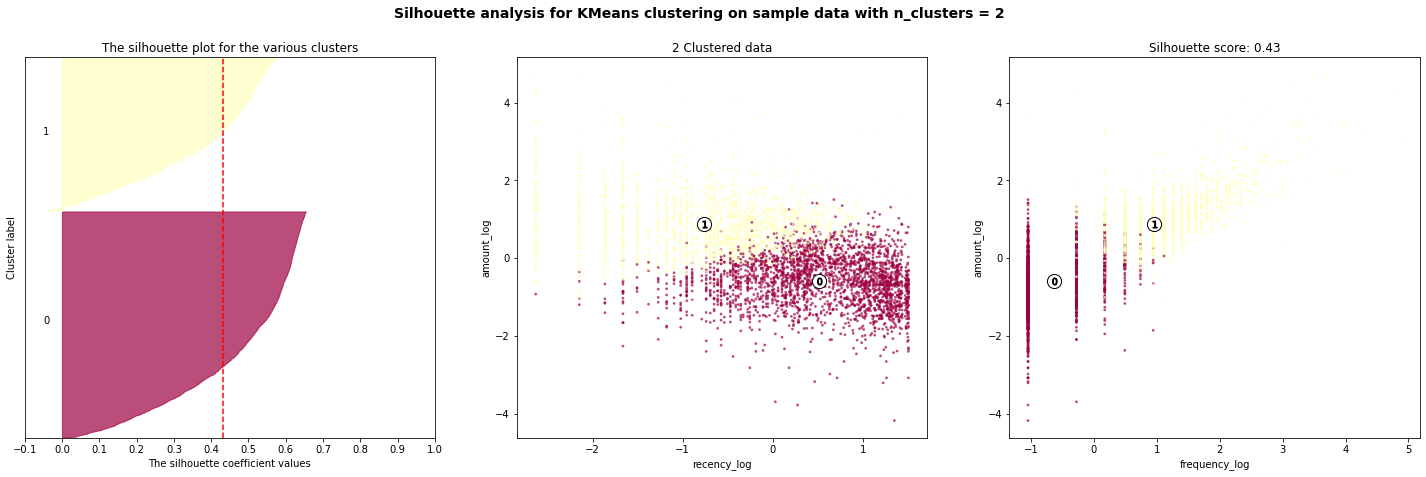

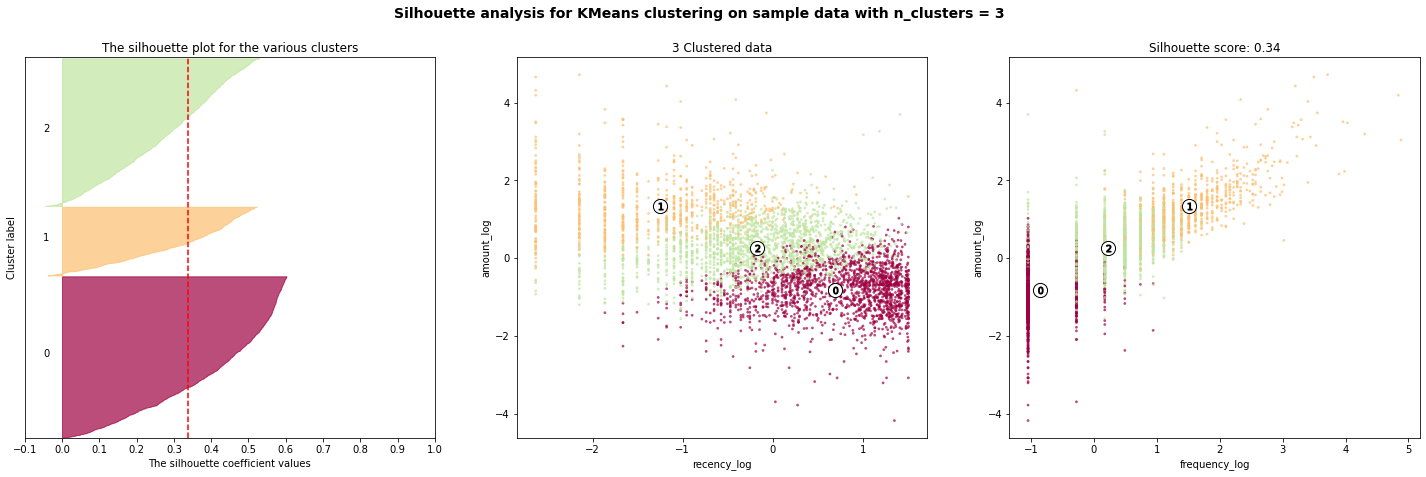

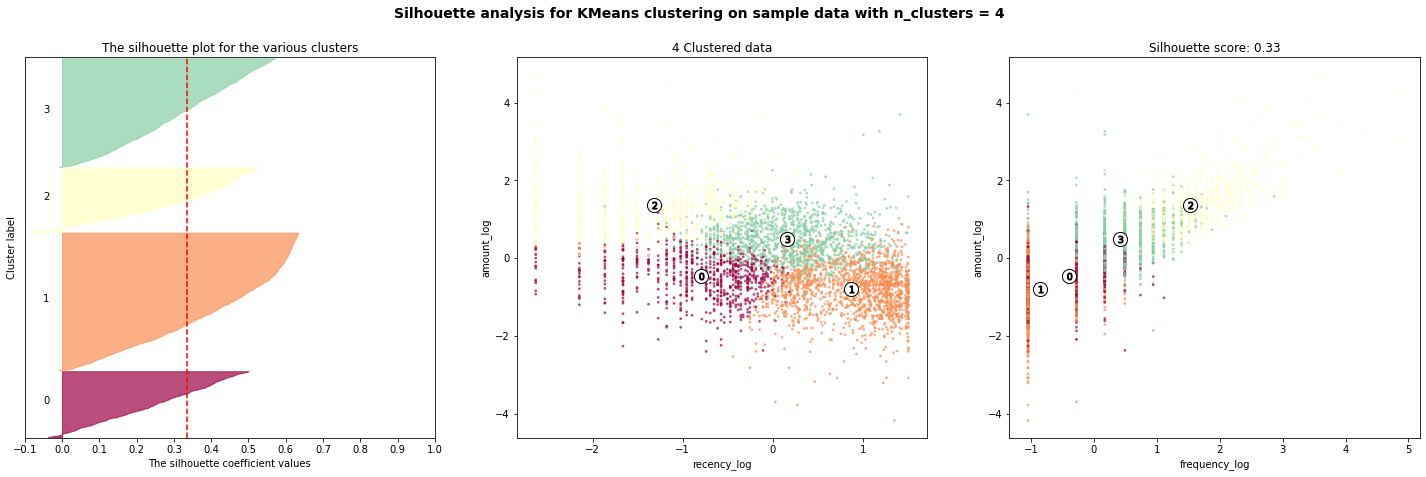

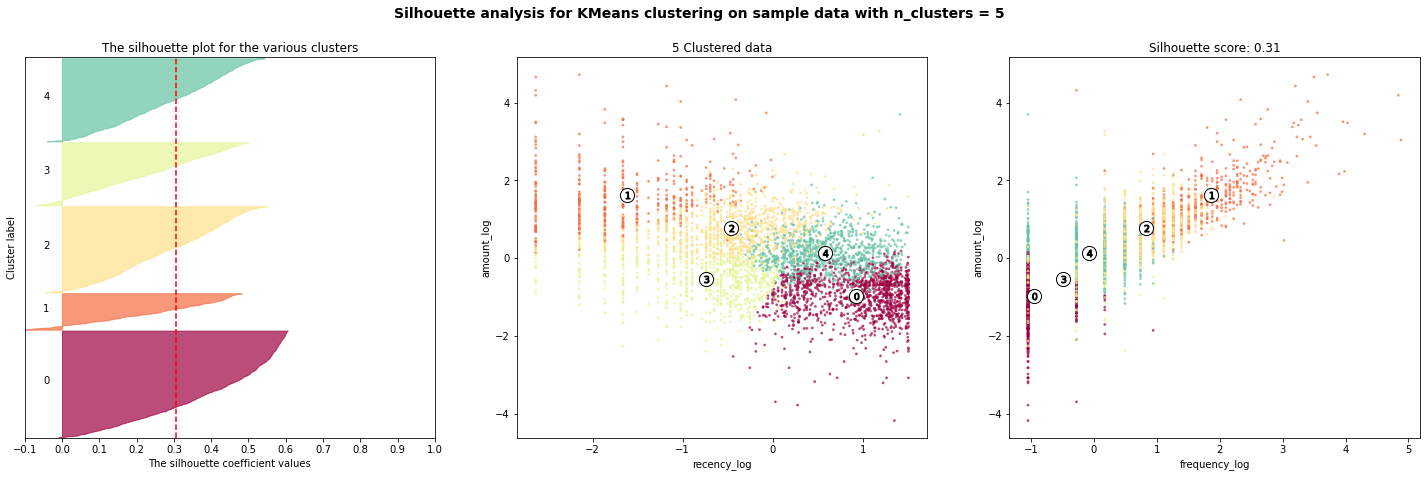

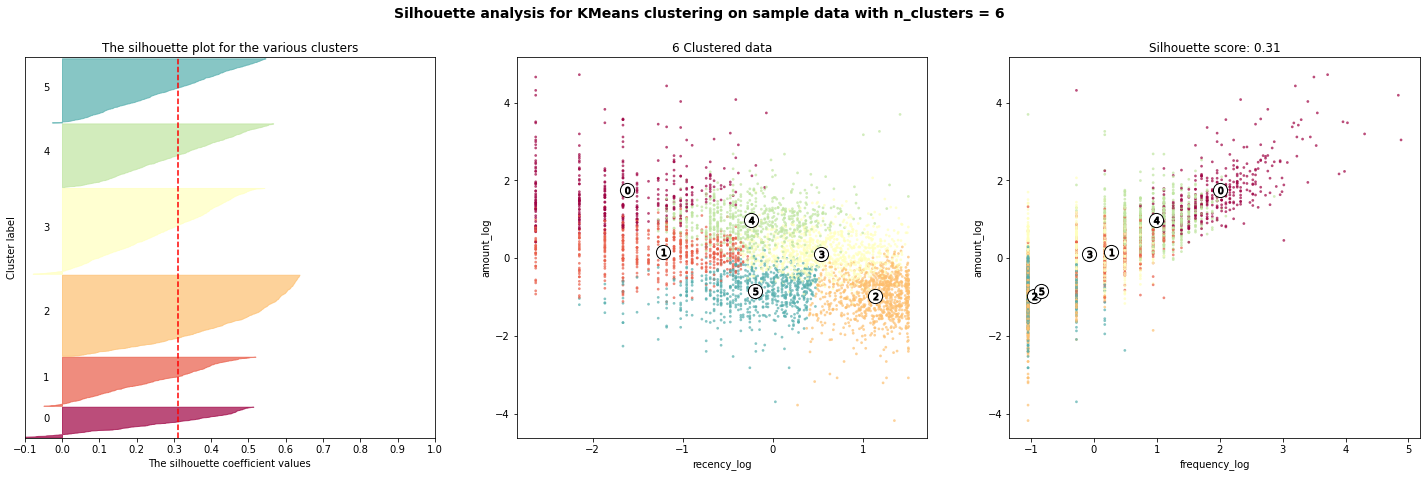

In [39]:
cluster_centers = dict()

for n_clusters in range(2,7):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

From the results of the clustering process we can say that all K clusters options is valid, because they don't have presence of clusters with below average silhouette scores. On the other hand, all options had a some wide fluctuations in the size of the silhouette plots.So, the best choice may lie on the option that gives us a simpler business explanation and at the same time target customers in focus groups with sizes closer to the desired.

###### Cluster center values after returning them to normal values from the log and scaled version.

In [40]:
features = ['amount',  'recency',  'frequency']
for i in range(2,7):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 2 clusters the silhouette score is 0.43
Centers of each cluster:
        amount    recency  frequency
0   344.557738  90.566375   1.445352
1  2212.744011  14.456305   6.048228
--------------------------------------------------
for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0   261.952265  116.604917   1.190876
1  3967.994380    7.236580  10.044493
2  1006.914317   33.819966   3.152227
--------------------------------------------------
for 4 clusters the silhouette score is 0.33
Centers of each cluster:
        amount     recency  frequency
0   411.019104   13.883384   1.808930
1   265.390258  149.631478   1.191878
2  4030.971509    6.568091  10.222665
3  1357.922739   54.467459   3.750873
--------------------------------------------------
for 5 clusters the silhouette score is 0.31
Centers of each cluster:
        amount     recency  frequency
0   213.438964  160.737849   1.088263
1  5708.668108    4.285608  13.677542
2  1

Clusters Behaviors:

In the Two-cluster:
Cluster 0 is the cluster of Low value customer who does not shops recently.
Cluster 1 is the cluster of high value customer who shops recently and it is certainly an important segment for each business.
Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency)

In the three-cluster:
Clusters 0 and 1 are very similar to their cluster in the configuration with only 2 clusters.
Cluster 1 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
In the similar way we obtain customer groups with low and medium spends in clusters with labels 0 and 2, respectively.
The silhouette score matrix says that the three cluster segments are less optimal then the two cluster segments.

In the four-cluster:
Clusters 0 and 1 has lower frequency but cluster 1's recency is very high.
Cluster 2 is a high value customer and shops recently.
Cluster 3 can be said as medium value customer and shops recently.

In the five-cluster:
Clusters 0 and 1 are very similar to their cluster in the configuration with only 3 clusters.
The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
The cluster 2 are those who have a decent spend but are not as frequent as the cluster 1
The cluster 3 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently.
The cluster 4 purchases medium amounts, with a relatively low frequency and not very recent
The silhouette score matrix says that the five cluster segments are less optimal then the three cluster segments.

In the six-cluster:
Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
Cluster 5 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.
Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.

###### We can label our data with the corresponding cluster label and then visualize these differences. 

In [41]:
customer_history_df['clusters_2'] = cluster_centers[2]['labels'] 
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_4'] = cluster_centers[4]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_6'] = cluster_centers[6]['labels'] 

display(customer_history_df)

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6
0,12346.0,326.0,1,77183.60,5.786897,0.000000,11.253942,1,2,3,4,4
1,12347.0,2.0,7,4310.00,0.693147,1.945910,8.368693,1,1,2,1,0
2,12348.0,75.0,4,1797.24,4.317488,1.386294,7.494007,1,2,3,4,3
3,12349.0,19.0,1,1757.55,2.944439,0.000000,7.471676,0,2,0,3,1
4,12350.0,310.0,1,334.40,5.736572,0.000000,5.812338,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...
4333,18280.0,278.0,1,180.60,5.627621,0.000000,5.196285,0,0,1,0,2
4334,18281.0,181.0,1,80.82,5.198497,0.000000,4.392224,0,0,1,0,2
4335,18282.0,8.0,2,178.05,2.079442,0.693147,5.182064,0,2,0,3,5
4336,18283.0,4.0,16,2094.88,1.386294,2.772589,7.647252,1,1,2,1,0


###### Visualizing how each clusters lies after labeling

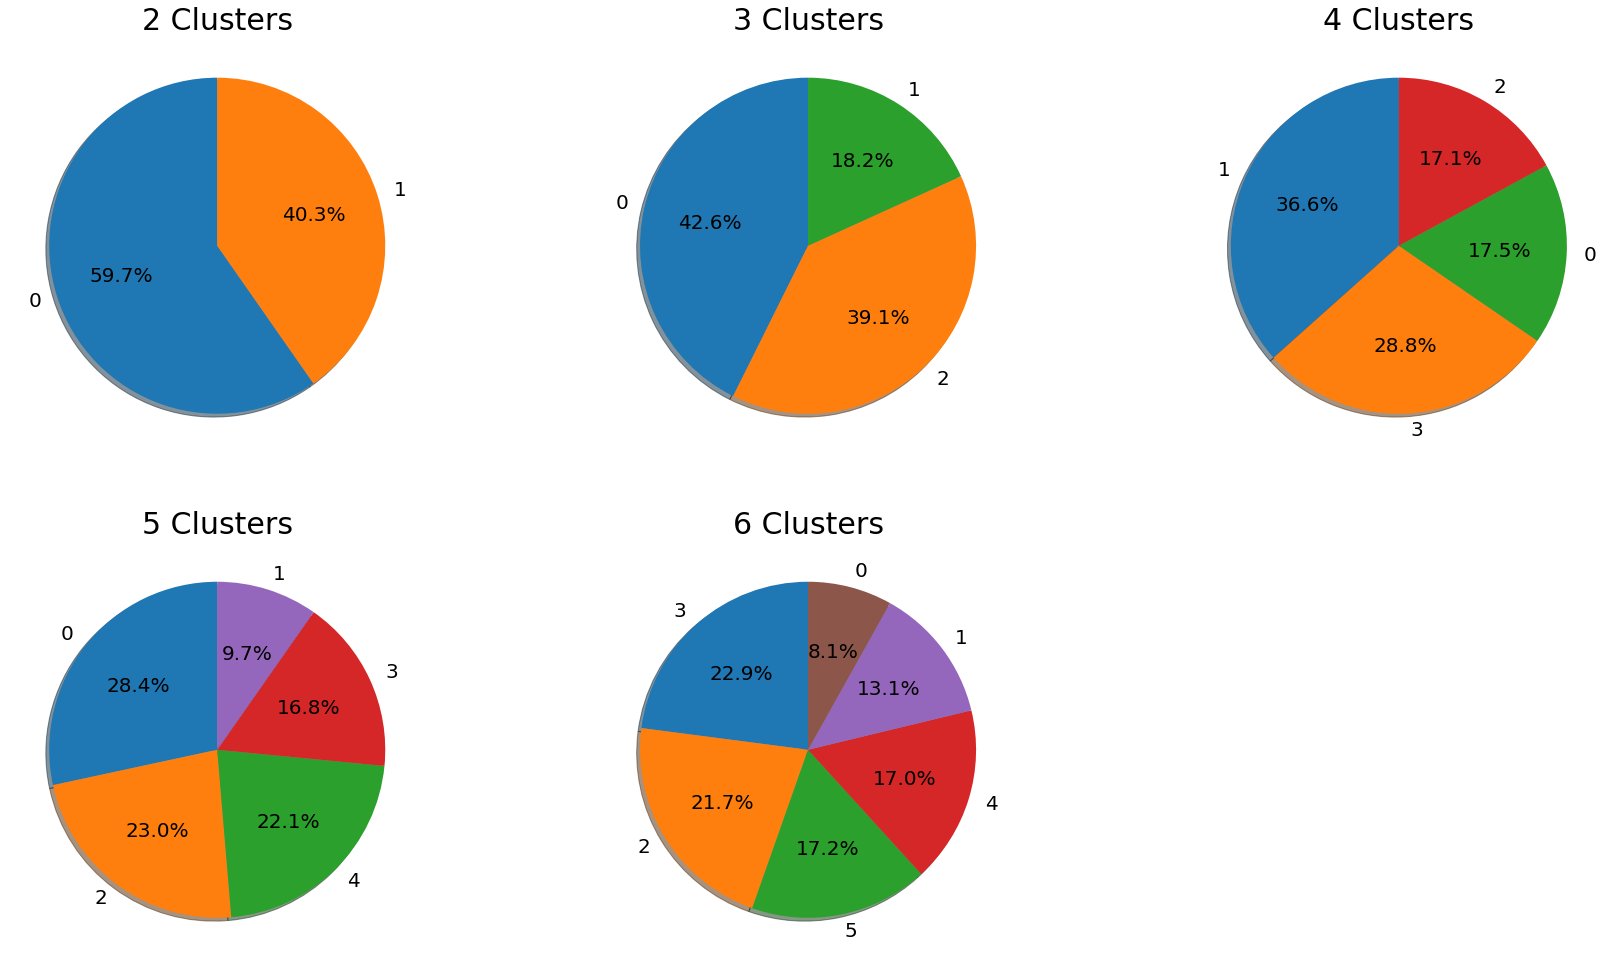

In [42]:
fig = plt.figure(figsize=(30,17))
textprops = {"fontsize":20}
f1 = fig.add_subplot(231)
market = customer_history_df.clusters_2.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90,textprops=textprops)
plt.title('2 Clusters',fontdict={'fontsize': 30})
f1 = fig.add_subplot(232)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90,textprops=textprops)
plt.title('3 Clusters',fontdict={'fontsize': 30})
f1 = fig.add_subplot(233)
market = customer_history_df.clusters_4.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90,textprops=textprops)
plt.title('4 Clusters',fontdict={'fontsize': 30})
f1 = fig.add_subplot(234)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90,textprops=textprops)
plt.title('5 Clusters',fontdict={'fontsize': 30})
f1 = fig.add_subplot(235)
market = customer_history_df.clusters_6.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90,textprops=textprops)
plt.title('6 Clusters',fontdict={'fontsize': 30})

plt.show()